In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from itertools import accumulate
import torch

In [2]:
nCells = (10,10,10)
cellSize = (3,3,12)
n = 2.2 # PWO refractive index
c0 = 299.792458/n # mm/ns
c = c0/n

In [3]:
def onAxis_SolidAngle(a, b, d):
    alpha = a/(2*d)
    beta  = b/(2*d)
    return 4*np.arcsin(alpha*beta/np.sqrt((1+alpha**2)*(1+beta**2)))

In [4]:
def offAxis_SolidAngle(A, B, a, b, d):
    sign_A = np.sign(A)
    A *= sign_A
    sign_B = np.sign(B)
    B *= sign_B

    o1 = onAxis_SolidAngle(2*(a+sign_A*A), 2*(b+sign_B*B), d)
    o2 = onAxis_SolidAngle(2*A,            2*(b+sign_B*B), d)
    o3 = onAxis_SolidAngle(2*(a+sign_A*A), 2*B,            d)
    o4 = onAxis_SolidAngle(2*A,            2*B,            d)

    return (o1 - sign_A*o2 - sign_B*o3 + sign_A*sign_B*o4)/4


In [5]:
def generate_tuples_two_integers(n):
    """
    Generate all tuples of two integers (a, b) such that
    the sum of their absolute values equals n.

    Parameters:
        n (int): Target sum of absolute values.

    Returns:
        list of tuples: List of (a, b) satisfying the condition.
    """
    result = []
    for a in range(-n, n + 1):  # Iterate over possible values of a
        b_abs = n - abs(a)      # Compute the absolute value of b
        if b_abs >= 0:          # Ensure b_abs is non-negative
            # Add both positive and negative combinations of b
            result.append((a, b_abs))
            if b_abs != 0:  # Avoid duplicates when b_abs is 0
                result.append((a, -b_abs))
    return result


def all_reflections(n):
    """
    Generate all possible reflection paths such that
    the total amount of reflections equals n. A reflection 
    path is a (x, y, z) tuple where each coordinate is a
    (positive or negative) integer which signifies the amount
    of times a ray reflected in that direction.
    Positive values mean that the ray first reflected in the face
    in the positive direction of the axis and viceversa.

    Parameters:
        n (int): Target number of reflections.

    Returns:
        list of tuples: List of (x,y,z) satisfying the condition.
    """
    paths_horizontal = generate_tuples_two_integers(n)
    paths_vertical = generate_tuples_two_integers(n-1)
    paths = [(x, 0, z) for x, z in paths_horizontal] + [(x, -1, z) for x, z in paths_vertical]
    return paths
    

([<matplotlib.axis.XTick at 0x7ff8721733d0>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20')])

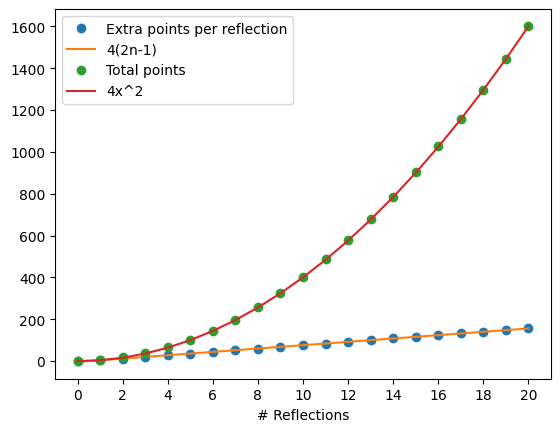

In [6]:
x = np.arange(0,21)
n_extra_point = [len(all_reflections(n)) for n in x]
total_point = list(accumulate(n_extra_point))
plt.plot(x, n_extra_point, 'o', label="Extra points per reflection")
plt.plot(x, 4*(2*x-1), '-', label='4(2n-1)')
plt.plot(x, total_point, 'o', label='Total points')
plt.plot(x, 4*x**2, label='4x^2')
plt.legend()
plt.xlabel("# Reflections")
plt.xticks(np.arange(0, 22, 2))

In [7]:
def reflect(old_coordinates, reflection, nCells=nCells):

    def reflect_onedim(old_coordinate, reflection, nCell):
        nc = old_coordinate
        if reflection != 0:
            sign = np.sign(reflection)
            reflection *= sign 
            partial_shift = reflection%2
            if partial_shift:
                if sign>0:
                    nc = 2*nCell-1-old_coordinate
                else:
                    nc = -1*old_coordinate-1
            whole_shifts = reflection//2
            nc += whole_shifts*sign*2*nCell
        return nc
    
    nc = [reflect_onedim(oc, r, n) for oc, r, n in zip(old_coordinates, reflection, nCells)]

    return nc

In [8]:
def find_distances(edep_idx, sensor_idx, cellSize=cellSize, nCells=nCells):
    shift_x = abs(edep_idx[0] - sensor_idx[0])
    if shift_x == 0:
        A = -0.5*cellSize[0]
    else:
        A = cellSize[0]*(shift_x-1+0.5)
    d = cellSize[1]*(nCells[1]-1-edep_idx[1]+0.5)
    shift_z = abs(edep_idx[2] - sensor_idx[1])
    if shift_z == 0:
        B = -0.5*cellSize[2]
    else:
        B = cellSize[2]*(shift_z-1+0.5)
    
    t = np.sqrt(d**2 + (shift_x*cellSize[0])**2 + (shift_z*cellSize[2])**2)/c

    return A, B, d, t

In [13]:
def compute_angles(edep_idx, sensor_idx, N, cellSize=cellSize):
    reflections = [all_reflections(n) for n in range(N+1)]
    new_coordinates = [[reflect(edep_idx, r) for r in ref] for ref in reflections]
    lengths = [[find_distances(edep, sensor_idx) for edep in n] for n in new_coordinates]
    omegas = [[offAxis_SolidAngle(A, B, cellSize[0], cellSize[2], d) for A, B, d, _ in l] for l in lengths]
    return omegas

In [ ]:
def compute_matrices(N):

    reflections = [all_reflections(n) for n in range(N+1)]

    new_coordinates = [[[[[reflect((x, y, z), r) for x in range(nCells[0])] # cell idz x
                                                 for y in range(nCells[1])] # cell idx y
                                                 for z in range(nCells[2])] # cell idx z
                                                 for r in ref]              # possible reflections fixing n
                                                 for ref in reflections]    # all different ns
        
    lengths = [[[[[[[find_distances(edep_x, (s_x, s_z)) for s_x in range(nCells[0])]   # sensor idx x
                                                        for s_z in range(nCells[2])]   # sensor idx z
                                                        for edep_x in edep_y]          # cell idx x
                                                        for edep_y in edep_z]          # cell idx y
                                                        for edep_z in edep_ref]        # cell idx z
                                                        for edep_ref in edep_n]        # possible reflections fixing n
                                                        for edep_n in new_coordinates] # all different ns

    omegas = [[[[[[[[offAxis_SolidAngle(A, B, cellSize[0], cellSize[2], d) for A, B, d in l] for l in lengths]
    times = []

    return omegas, times

In [ ]:
N = 5
reflections = [all_reflections(n) for n in range(N+1)]
new_coordinates = [[[[[reflect((x, y, z), r) for x in range(nCells[0])]
                                                     for y in range(nCells[1])]
                                                      for z in range(nCells[2])]
                                                      for r in ref]
                                                      for ref in reflections]

In [ ]:
lengths = [[[[[[[find_distances(edep_x, (s_x, s_z)) for s_x in range(nCells[0])]
                                                 for s_z in range(nCells[2])]
                                                 for edep_x in edep_y]
                                                 for edep_y in edep_z]
                                                 for edep_z in edep_ref]
                                                 for edep_ref in edep_n]
                                                 for edep_n in new_coordinates]

In [ ]:
import sys
def total_size(obj, seen=None):
    """Recursively find the size of an object, including referenced objects."""
    if seen is None:
        seen = set()

    obj_id = id(obj)
    if obj_id in seen:
        return 0
    seen.add(obj_id)

    size = sys.getsizeof(obj)
    if isinstance(obj, dict):
        size += sum(total_size(k, seen) + total_size(v, seen) for k, v in obj.items())
    elif isinstance(obj, (list, tuple, set)):
        size += sum(total_size(i, seen) for i in obj)

    return size
total_size(lengths)

In [ ]:
a = [[10*y+x for x in range(3)] for y in range(5)]
print(a)
print(a[0][2])

In [ ]:
a = torch.rand(3,5)
print(a)
print(a[0][2])

In [ ]:
o = torch.zeros(*nCells, *(nCells[0,2]))

In [ ]:
o.size()

In [ ]:
N = 6
edep_idx = (0,2,4)
reflections = [all_reflections(n) for n in range(N+1)]
new_coordinates = [[reflect(edep_idx, r) for r in ref] for ref in reflections]

In [ ]:
from itertools import chain
a = list(chain.from_iterable(reflections))
len(a)

In [ ]:
for n in reflections:
    print(len(n))
    print(type(n[0]))

In [14]:
N = 5
edep_idx = (0,0,0)
sensor_idx = (9,9)
omegas = compute_angles(edep_idx, sensor_idx, N)

In [ ]:
omega_sum = [np.sum(x) for x in omegas]
omega_cum = list(accumulate(omega_sum))

In [ ]:
x = 6
plt.title("New Solid Angle coverage added by each reflection")
plt.ylabel("Solid Angle [srad]")
plt.xlabel("# Reflections")
plt.plot(np.arange(x), omega_sum[:x], 'o')
plt.plot(np.arange(x), omega_sum[:x], '--', color="lightblue")

In [ ]:
x = 6
plt.title("Total Solid Angle coverage")
plt.ylabel("Solid Angle [srad]")
plt.xlabel("# Reflections")
plt.plot(np.arange(x), omega_cum[:x], 'o')
plt.plot(np.arange(x), omega_cum[:x], '--', color="lightblue")

In [20]:
a = [0,2,3,4]
for i, n in enumerate(a):
    print(i, n)

0 0
1 2
2 3
3 4


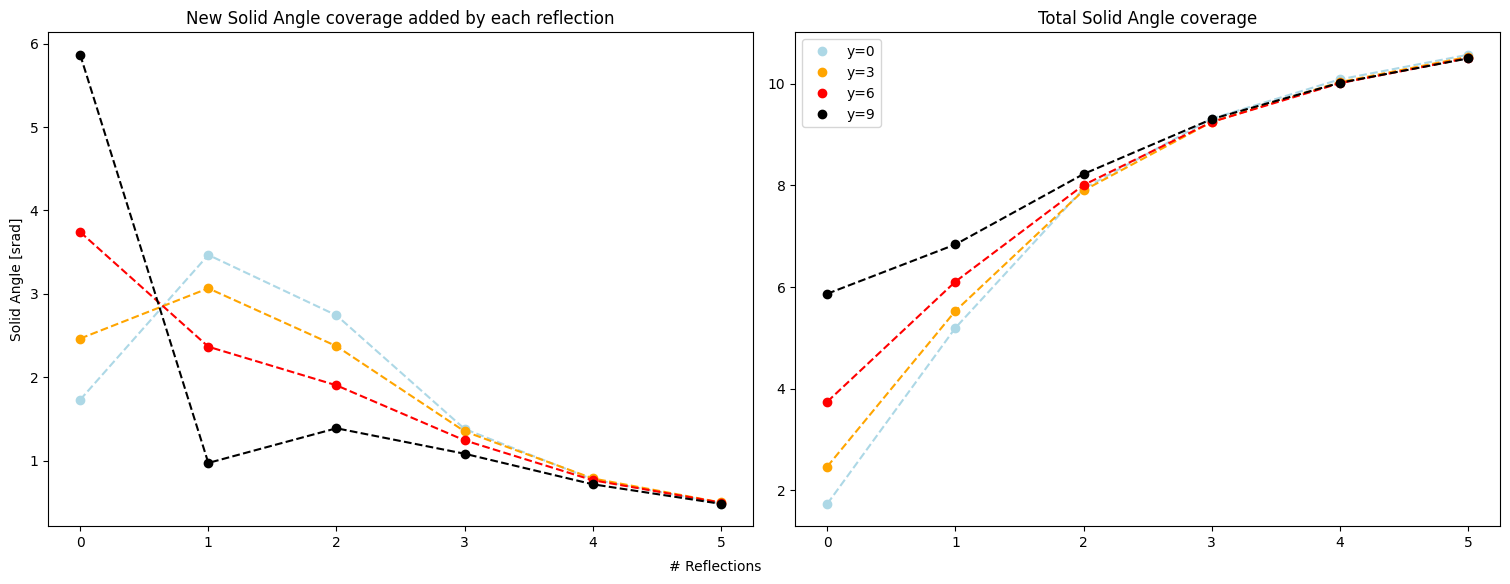

In [38]:
N = 5
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
edep_idx=[(5,y,5) for y in [0,3,6,9]]
col=['lightblue', 'orange', 'red', 'black']
for i, edep in enumerate(edep_idx):
    tot_sum = []
    tot_cum = []
    for x_i in range(nCells[0]):
        for z_i in range(nCells[2]):
            omegas = compute_angles(edep, (x_i, z_i), N)
            omega_sum = [np.sum(x) for x in omegas]
            omega_cum = list(accumulate(omega_sum))

            tot_sum.append(omega_sum)
            tot_cum.append(omega_cum)

    full_sum = [sum(values) for values in zip(*tot_sum)]
    full_cum = [sum(values) for values in zip(*tot_cum)]

    ax[0].plot(np.arange(N+1), full_sum, 'o',  color=col[i], label=f'y={edep[1]}')
    ax[0].plot(np.arange(N+1), full_sum, '--', color=col[i])

    ax[1].plot(np.arange(N+1), full_cum, 'o',  color=col[i], label=f'y={edep[1]}')
    ax[1].plot(np.arange(N+1), full_cum, '--', color=col[i])

ax[0].set_title("New Solid Angle coverage added by each reflection")
ax[1].set_title("Total Solid Angle coverage")
ax[0].set_ylabel("Solid Angle [srad]")
fig.text(0.5, 0.04, '# Reflections', ha='center')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
ax[1].legend()

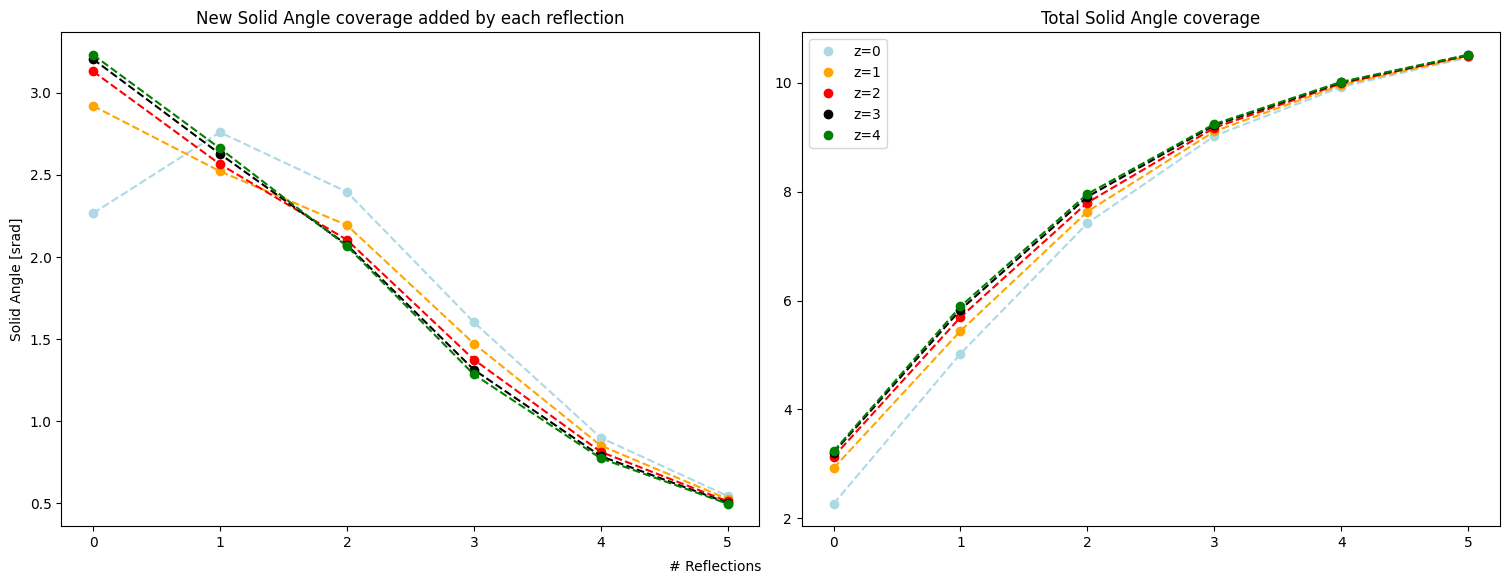

In [40]:
N = 5
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
edep_idx=[(5,5,z) for z in [0,1,2,3,4]]
col=['lightblue', 'orange', 'red', 'black', 'green']
for i, edep in enumerate(edep_idx):
    tot_sum = []
    tot_cum = []
    for x_i in range(nCells[0]):
        for z_i in range(nCells[2]):
            omegas = compute_angles(edep, (x_i, z_i), N)
            omega_sum = [np.sum(x) for x in omegas]
            omega_cum = list(accumulate(omega_sum))

            tot_sum.append(omega_sum)
            tot_cum.append(omega_cum)

    full_sum = [sum(values) for values in zip(*tot_sum)]
    full_cum = [sum(values) for values in zip(*tot_cum)]

    ax[0].plot(np.arange(N+1), full_sum, 'o',  color=col[i], label=f'z={edep[2]}')
    ax[0].plot(np.arange(N+1), full_sum, '--', color=col[i])

    ax[1].plot(np.arange(N+1), full_cum, 'o',  color=col[i], label=f'z={edep[2]}')
    ax[1].plot(np.arange(N+1), full_cum, '--', color=col[i])

ax[0].set_title("New Solid Angle coverage added by each reflection")
ax[1].set_title("Total Solid Angle coverage")
ax[0].set_ylabel("Solid Angle [srad]")
fig.text(0.5, 0.04, '# Reflections', ha='center')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
ax[1].legend()

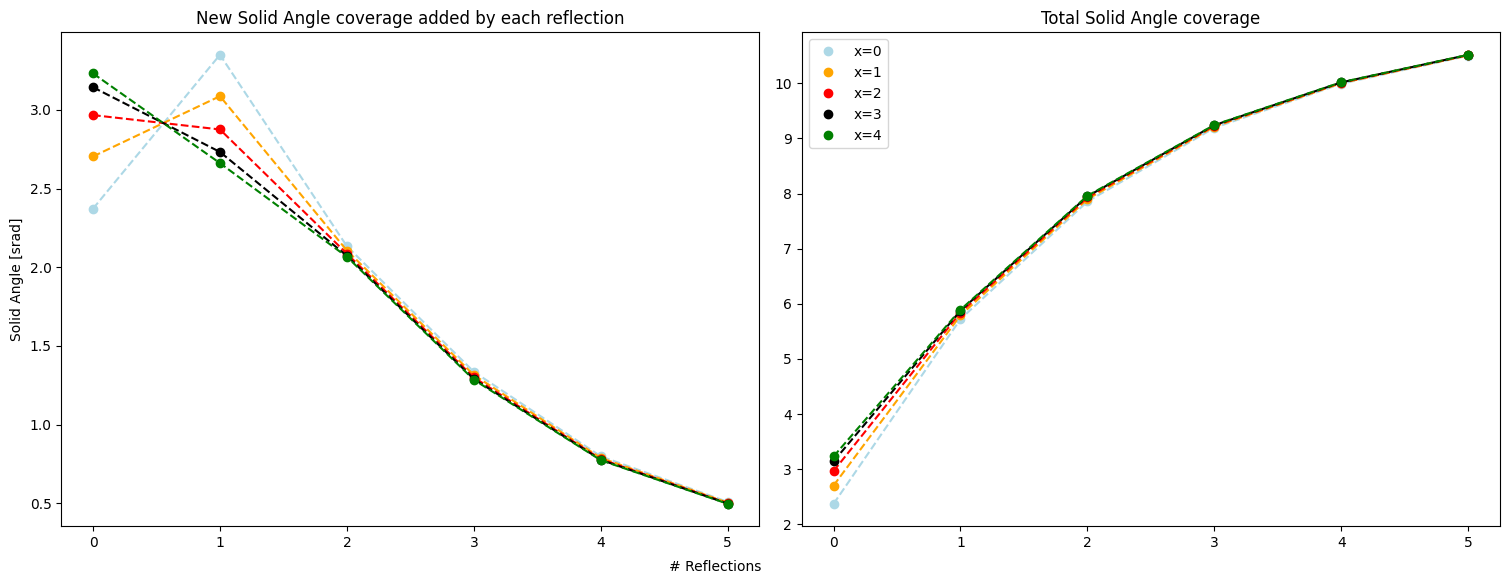

In [42]:
N = 5
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
edep_idx=[(x,5,5) for x in [0,1,2,3,4]]
col=['lightblue', 'orange', 'red', 'black', 'green']
for i, edep in enumerate(edep_idx):
    tot_sum = []
    tot_cum = []
    for x_i in range(nCells[0]):
        for z_i in range(nCells[2]):
            omegas = compute_angles(edep, (x_i, z_i), N)
            omega_sum = [np.sum(x) for x in omegas]
            omega_cum = list(accumulate(omega_sum))

            tot_sum.append(omega_sum)
            tot_cum.append(omega_cum)

    full_sum = [sum(values) for values in zip(*tot_sum)]
    full_cum = [sum(values) for values in zip(*tot_cum)]

    ax[0].plot(np.arange(N+1), full_sum, 'o',  color=col[i], label=f'x={edep[0]}')
    ax[0].plot(np.arange(N+1), full_sum, '--', color=col[i])

    ax[1].plot(np.arange(N+1), full_cum, 'o',  color=col[i], label=f'x={edep[0]}')
    ax[1].plot(np.arange(N+1), full_cum, '--', color=col[i])

ax[0].set_title("New Solid Angle coverage added by each reflection")
ax[1].set_title("Total Solid Angle coverage")
ax[0].set_ylabel("Solid Angle [srad]")
fig.text(0.5, 0.04, '# Reflections', ha='center')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
ax[1].legend()

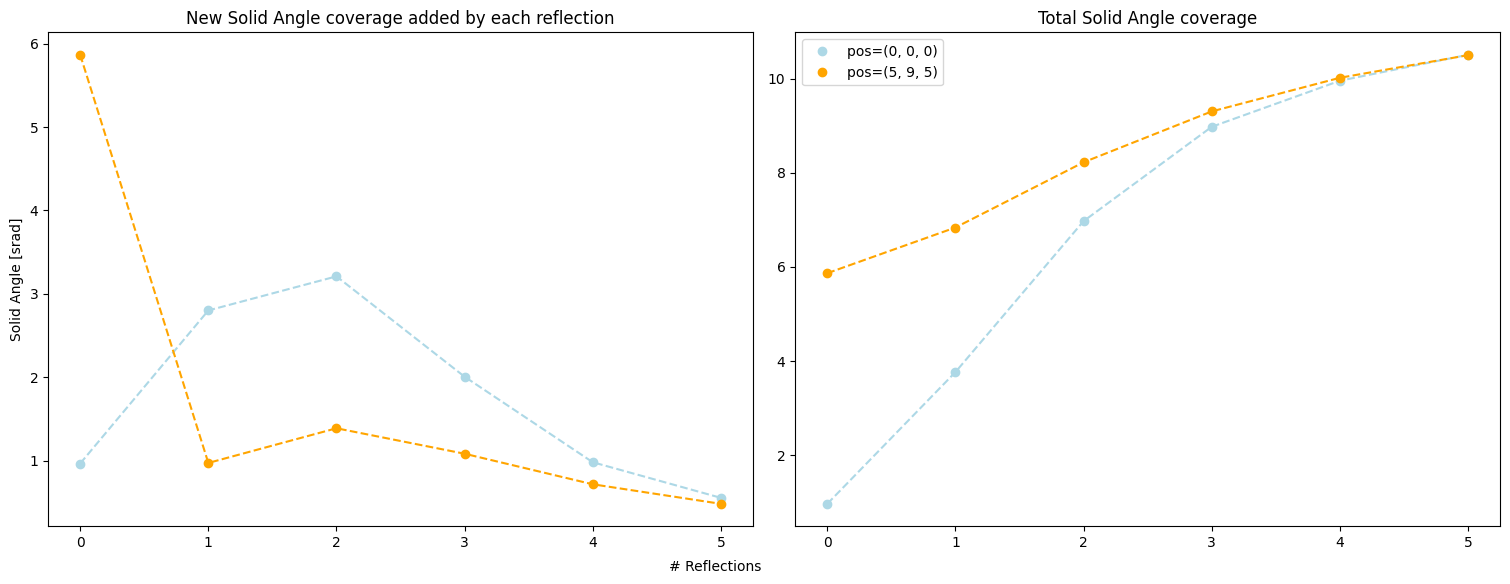

In [43]:
N = 5
fig, ax = plt.subplots(ncols=2, figsize=(16,6))
edep_idx=[(0,0,0), (5,9,5)]
col=['lightblue', 'orange', 'red', 'black', 'green']
for i, edep in enumerate(edep_idx):
    tot_sum = []
    tot_cum = []
    for x_i in range(nCells[0]):
        for z_i in range(nCells[2]):
            omegas = compute_angles(edep, (x_i, z_i), N)
            omega_sum = [np.sum(x) for x in omegas]
            omega_cum = list(accumulate(omega_sum))

            tot_sum.append(omega_sum)
            tot_cum.append(omega_cum)

    full_sum = [sum(values) for values in zip(*tot_sum)]
    full_cum = [sum(values) for values in zip(*tot_cum)]

    ax[0].plot(np.arange(N+1), full_sum, 'o',  color=col[i], label=f'pos={edep}')
    ax[0].plot(np.arange(N+1), full_sum, '--', color=col[i])

    ax[1].plot(np.arange(N+1), full_cum, 'o',  color=col[i], label=f'pos={edep}')
    ax[1].plot(np.arange(N+1), full_cum, '--', color=col[i])

ax[0].set_title("New Solid Angle coverage added by each reflection")
ax[1].set_title("Total Solid Angle coverage")
ax[0].set_ylabel("Solid Angle [srad]")
fig.text(0.5, 0.04, '# Reflections', ha='center')
plt.tight_layout(rect=[0.05, 0.05, 1, 1])
ax[1].legend()

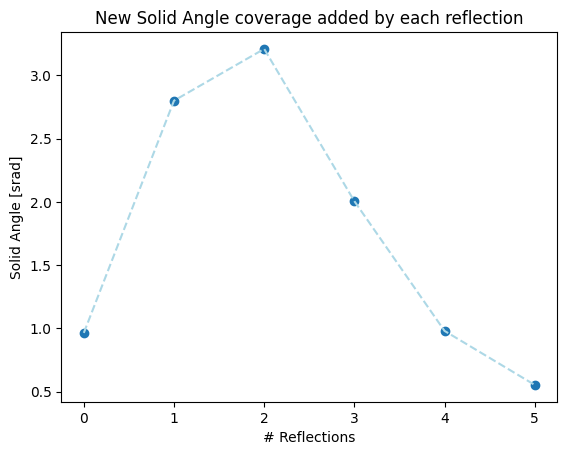

In [16]:
full_sum = [sum(values) for values in zip(*tot_sum)]
x = 6
plt.title("New Solid Angle coverage added by each reflection")
plt.ylabel("Solid Angle [srad]")
plt.xlabel("# Reflections")
plt.plot(np.arange(x), full_sum[:x], 'o')
plt.plot(np.arange(x), full_sum[:x], '--', color="lightblue")

In [3]:
a = [1,2,3]
b = [84,4,3]
c = list(zip(a,b))
c

[(1, 84), (2, 4), (3, 3)]

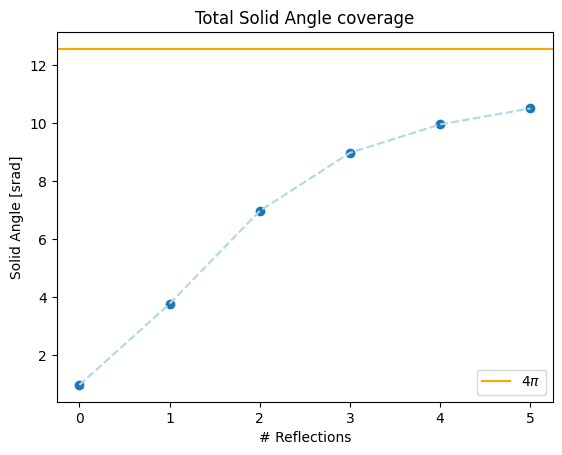

In [17]:
full_cum = [sum(values) for values in zip(*tot_cum)]
x = 6
plt.axhline(4*np.pi, label="$4\pi$", color='orange')
plt.title("Total Solid Angle coverage")
plt.ylabel("Solid Angle [srad]")
plt.xlabel("# Reflections")
plt.plot(np.arange(x), full_cum[:x], 'o')
plt.plot(np.arange(x), full_cum[:x], '--', color="lightblue")
plt.legend()

## Simulate Fake Event

In [ ]:
import torch
a = torch.rand((100, 10, 10, 10, 10, 10))

In [ ]:
a.nelement() * a.element_size()